# E-commerce Customer Behavior Analysis

### Portfolio Project

This notebook analyzes an E-commerce dataset using **SQL + Python** to extract insights about **customer behavior, sales trends, and payment patterns**.

**Skills Demonstrated:**
- Data Loading into SQLite  
- SQL Querying for business questions  
- Python (Pandas, Matplotlib, Seaborn) for visualization  
- Customer segmentation and behavior analysis  
- Revenue and time-based trend analysis  
- Business insights & recommendations  

---


In [ ]:
# Step 1: Data Loading into SQLite
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

csv_files = {
    "/kaggle/input/target-dataset/customers.csv": "customers",
    "/kaggle/input/target-dataset/geolocation.csv": "geolocation",
    "/kaggle/input/target-dataset/order_items.csv": "order_items",
    "/kaggle/input/target-dataset/orders.csv": "orders",
    "/kaggle/input/target-dataset/payments.csv": "payments",
    "/kaggle/input/target-dataset/products.csv": "products",
    "/kaggle/input/target-dataset/sellers.csv": "sellers"
}
db = sqlite3.connect('ecommerce_data.db')


for file_path, table_name in csv_files.items():
    try:
        df = pd.read_csv(file_path)
        df.to_sql(table_name, con=db, if_exists='replace', index=False)
        print(f"✅ Imported '{file_path}' into table '{table_name}'")
    except Exception as e:
        print(f"❌ Failed to import '{file_path}': {e}")

In [2]:
cur = db.cursor()

In [ ]:
# it will select the districs from the list
query = """ SELECT DISTINCT customer_city from customers """

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


In [4]:
# it will count the number of orders placed in 2017
query = """
SELECT COUNT(order_id)
FROM orders
WHERE strftime('%Y', order_purchase_timestamp) = '2017'
"""

cur.execute(query)
data = cur.fetchall()
print("📦 Total orders placed in 2017 are:", data[0][0])


📦 Total orders placed in 2017 are: 45101


In [5]:
import pandas as pd
import sqlite3

# Load CSVs (update paths if needed)
orders = pd.read_csv("/kaggle/input/target-dataset/orders.csv", parse_dates=["order_purchase_timestamp"])
payments = pd.read_csv("/kaggle/input/target-dataset/payments.csv")

# Create SQLite DB
conn = sqlite3.connect("ecommerce.db")
orders.to_sql("orders", conn, if_exists="replace", index=False)
payments.to_sql("payments", conn, if_exists="replace", index=False)

103886

In [ ]:
# Step 2: SQL Analysis
query = """
WITH delivered_orders AS (
    SELECT o.customer_id, o.order_id, o.order_purchase_timestamp, p.payment_value
    FROM orders o
    JOIN payments p ON o.order_id = p.order_id
    WHERE o.order_status = 'delivered'
),
customer_behavior AS (
    SELECT
        customer_id,
        COUNT(order_id) AS total_orders,
        SUM(payment_value) AS total_spent,
        MAX(order_purchase_timestamp) AS last_order
    FROM delivered_orders
    GROUP BY customer_id
)
SELECT *,
    CAST(julianday('2018-10-17') - julianday(last_order) AS INTEGER) AS recency_days,
    CASE 
        WHEN total_orders = 1 THEN 'New'
        ELSE 'Returning'
    END AS customer_type
FROM customer_behavior
ORDER BY total_spent DESC
LIMIT 10;
"""

# Run query
cur = conn.cursor()
cur.execute(query)
data = cur.fetchall()

# Convert to DataFrame
columns = [desc[0] for desc in cur.description]
df = pd.DataFrame(data, columns=columns)
df.head()

,customer_id,total_orders,total_spent,last_order,recency_days,customer_type
0,1617b1357756262bfa56ab541c47bc16,1,13664.08,2017-09-29 15:24:52,382,New
1,ec5b2ba62e574342386871631fafd3fc,1,7274.88,2018-07-15 14:49:44,93,New
2,c6e2731c5b391845f6800c97401a43a9,1,6929.31,2017-02-12 20:37:36,611,New
3,f48d464a0baaea338cb25f816991ab1f,1,6922.21,2018-07-25 18:10:17,83,New
4,3fd6777bbce08a352fddd04e4a7cc8f6,1,6726.66,2017-05-24 18:14:34,510,New


/tmp/ipykernel_13/67352702.py:18: UserWarning: Glyph 128184 (\N{MONEY WITH WINGS}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128184 (\N{MONEY WITH WINGS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


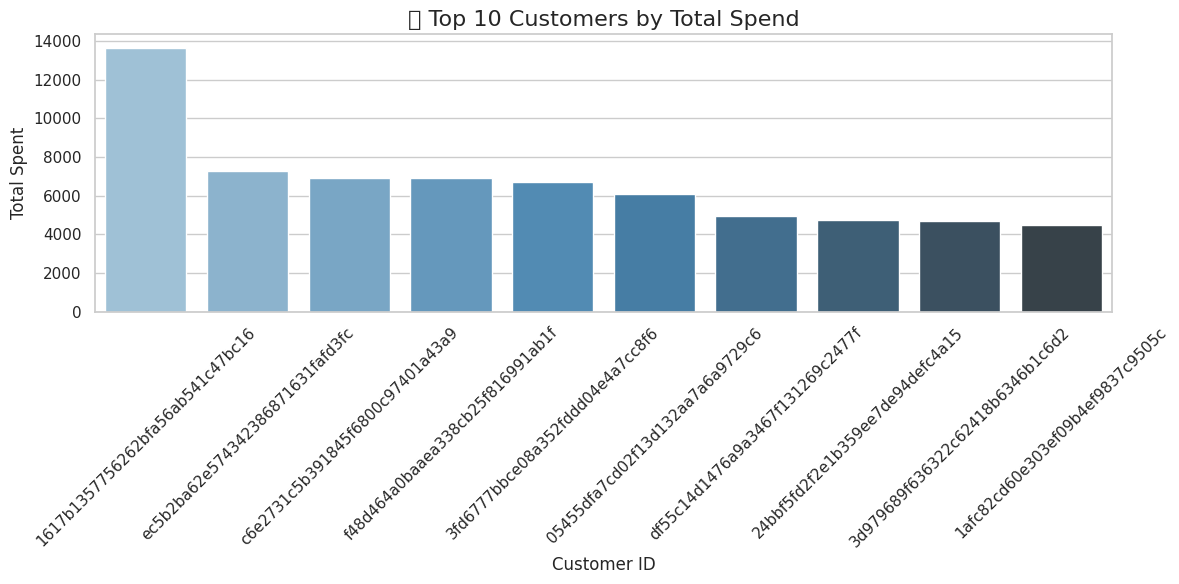

In [ ]:
# Step 3: Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# Sort by spending
df_sorted = df.sort_values(by="total_spent", ascending=False)

# Barplot: Top 10 spenders
plt.figure(figsize=(12, 6))
sns.barplot(data=df_sorted, x="customer_id", y="total_spent", palette="Blues_d")

plt.title("💸 Top 10 Customers by Total Spend", fontsize=16)
plt.xlabel("Customer ID")
plt.ylabel("Total Spent")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/tmp/ipykernel_13/1120789437.py:21: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


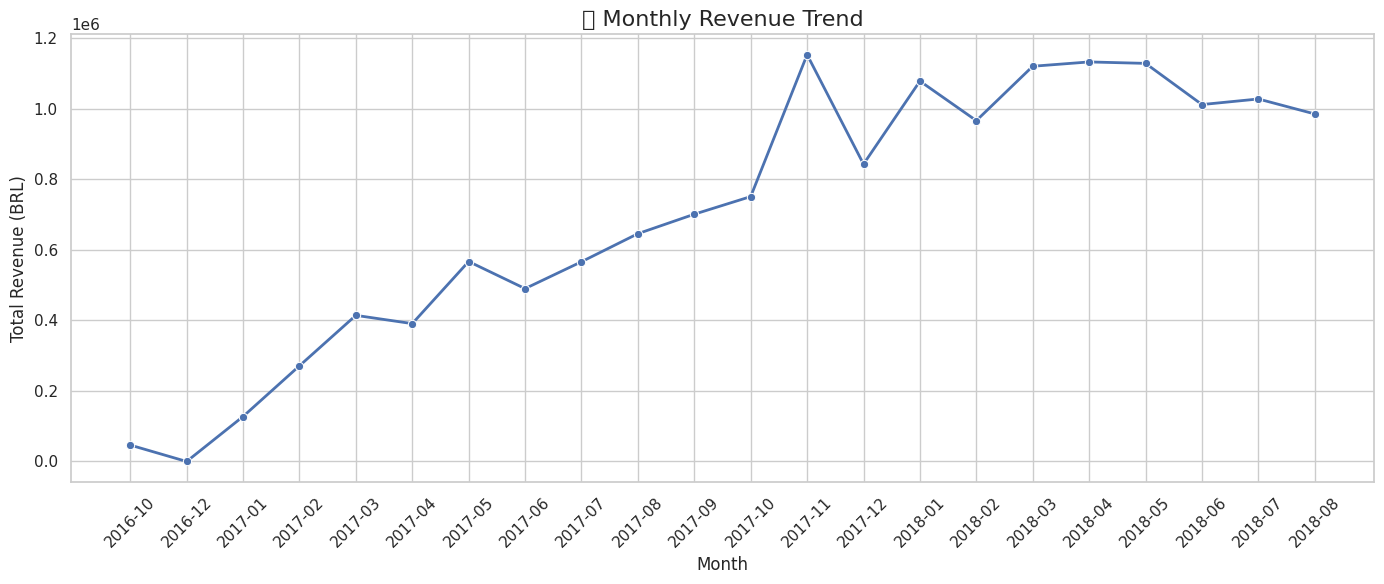

In [8]:
# Group by month and sum payments
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])

monthly_sales = orders[orders['order_status'] == 'delivered'].merge(
    payments, on='order_id'
)

monthly_sales['month'] = monthly_sales['order_purchase_timestamp'].dt.to_period('M')
monthly_summary = monthly_sales.groupby('month')['payment_value'].sum().reset_index()
monthly_summary['month'] = monthly_summary['month'].astype(str)  # Convert Period to string for plotting

# line graph to show total customer spend over time

plt.figure(figsize=(14, 6))
sns.lineplot(data=monthly_summary, x='month', y='payment_value', marker='o', linewidth=2)

plt.title('📈 Monthly Revenue Trend', fontsize=16)
plt.xlabel('Month')
plt.ylabel('Total Revenue (BRL)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/tmp/ipykernel_13/2117130314.py:23: UserWarning: Glyph 128717 (\N{SHOPPING BAGS}) missing from current font.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128717 (\N{SHOPPING BAGS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


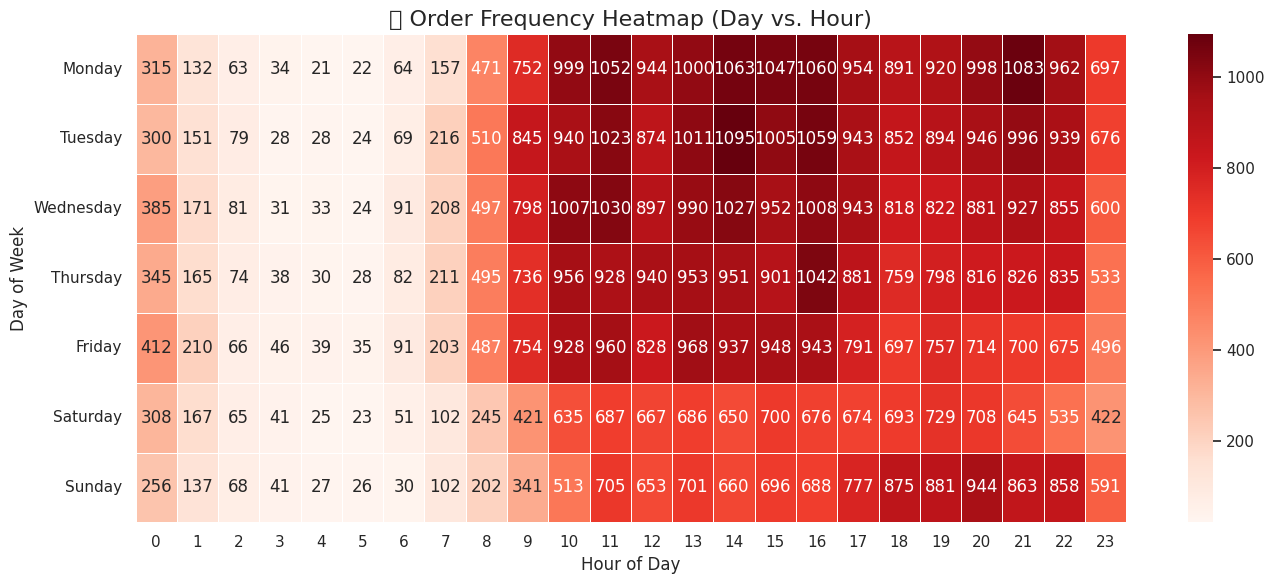

In [ ]:
# Step 4 Customer Behavior by Time (Heatmap)
# the amount of orders by day and week
orders['hour'] = orders['order_purchase_timestamp'].dt.hour
orders['day'] = orders['order_purchase_timestamp'].dt.day_name()

# Filter only delivered orders
delivered = orders[orders['order_status'] == 'delivered']

# Create pivot table
heatmap_data = delivered.pivot_table(
    index='day', columns='hour', values='order_id', aggfunc='count'
)

# Reorder days
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
heatmap_data = heatmap_data.reindex(ordered_days)

plt.figure(figsize=(14, 6))
sns.heatmap(heatmap_data, cmap='Reds', linewidths=0.5, annot=True, fmt=".0f")

plt.title('🛍️ Order Frequency Heatmap (Day vs. Hour)', fontsize=16)
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.tight_layout()
plt.show()


In [10]:
# percentage of order that were paid in anstallments
query = """
SELECT 
  100.0 * SUM(CASE WHEN payment_installments >= 1 THEN 1 ELSE 0 END) / COUNT(*) AS installment_percentage
FROM payments;
"""

cur.execute(query)

data = cur.fetchall()

"the percentage of orders that were paid in installments is", data[0][0]


('the percentage of orders that were paid in installments is',
 99.99807481277554)

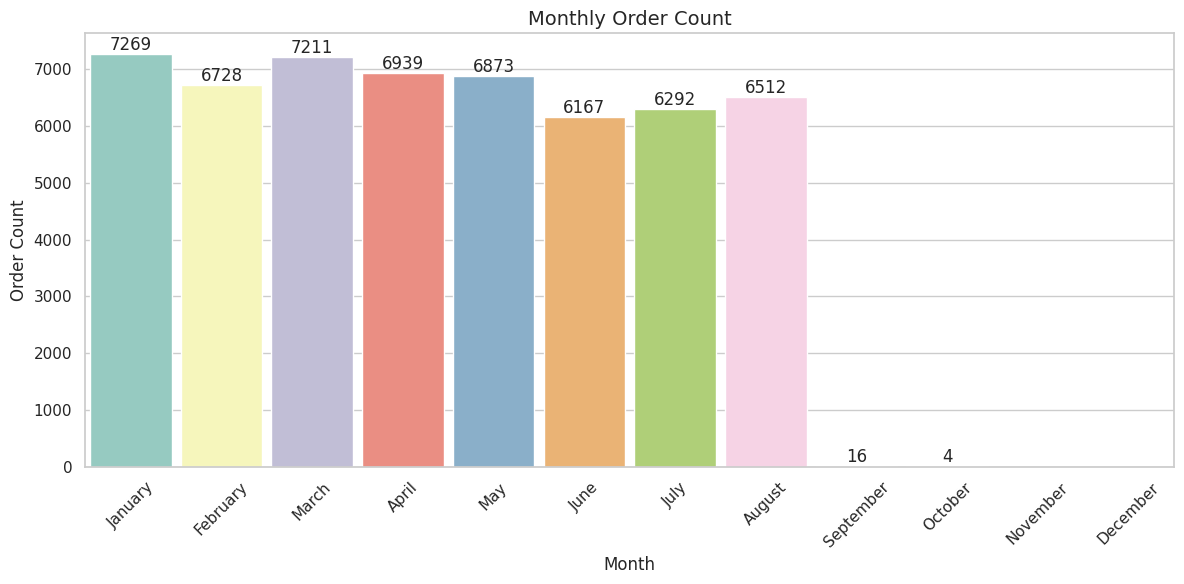

In [11]:
query = """
SELECT strftime('%m', order_purchase_timestamp) AS month_num,
       COUNT(order_id) AS order_count
FROM orders
WHERE strftime('%Y', order_purchase_timestamp) = '2018'
GROUP BY month_num
ORDER BY month_num
"""

cur.execute(query)
data = cur.fetchall()

# Create DataFrame
df = pd.DataFrame(data, columns=["months", "order_count"])

# Create DataFrame
df = pd.DataFrame(data, columns=["months", "order_count"])

# Map month numbers to month names
month_map = {
    "01": "January", "02": "February", "03": "March", "04": "April",
    "05": "May", "06": "June", "07": "July", "08": "August",
    "09": "September", "10": "October", "11": "November", "12": "December"
}
df["months"] = df["months"].map(month_map)

# Define month order for plotting
month_order = ["January", "February", "March", "April", "May", "June",
               "July", "August", "September", "October", "November", "December"]

# Plot
plt.figure(figsize=(12, 6))
ax = sns.barplot(
    x='months',
    y='order_count',
    data=df,
    order=month_order,
    palette='Set3',
    width=0.9  # ✅ Correct width
)

# Optional: Hide legend (no hue, so no legend anyway)
# ax.legend_.remove()

plt.xticks(rotation=45)
plt.title("Monthly Order Count", fontsize=14)
plt.xlabel("Month")
plt.ylabel("Order Count")

# Label each bar
for container in ax.containers:
    ax.bar_label(container)

plt.tight_layout()
plt.show()

In [ ]:
# loading customer data
query = """

SELECT years, customer_id, payment, d_rank 
FROM (
    SELECT 
        strftime('%Y', orders.order_purchase_timestamp) AS years,
        orders.customer_id,
        SUM(payments.payment_value) AS payment,
        DENSE_RANK() OVER (
            PARTITION BY strftime('%Y', orders.order_purchase_timestamp)
            ORDER BY SUM(payments.payment_value) DESC
        ) AS d_rank
    FROM orders 
    JOIN payments ON payments.order_id = orders.order_id
    GROUP BY years, orders.customer_id
) AS a
WHERE d_rank <= 3;


"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns= ['years', 'id', 'payment', 'rank'])

df

,years,id,payment,rank
0,2016,a9dc96b027d1252bbac0a9b72d837fc6,1423.55,1
1,2016,1d34ed25963d5aae4cf3d7f3a4cda173,1400.74,2
2,2016,4a06381959b6670756de02e07b83815f,1227.78,3
3,2017,1617b1357756262bfa56ab541c47bc16,13664.08,1
4,2017,c6e2731c5b391845f6800c97401a43a9,6929.31,2
5,2017,3fd6777bbce08a352fddd04e4a7cc8f6,6726.66,3
6,2018,ec5b2ba62e574342386871631fafd3fc,7274.88,1
7,2018,f48d464a0baaea338cb25f816991ab1f,6922.21,2
8,2018,e0a2412720e9ea4f26c1ac985f6a7358,4809.44,3


In [ ]:
# demonstrating yearly and monthly payment
query = """ 

SELECT 
    years, 
    months, 
    payment, 
    SUM(payment) OVER (ORDER BY years, months) AS cumulative_sales
FROM (
    SELECT 
        strftime('%Y', orders.order_purchase_timestamp) AS years,
        strftime('%m', orders.order_purchase_timestamp) AS months,
        ROUND(SUM(payments.payment_value), 2) AS payment
    FROM orders 
    JOIN payments ON orders.order_id = payments.order_id
    GROUP BY years, months
    ORDER BY years, months
) AS a


"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns=['years','months','payment','cumulative_sales'])
df


,years,months,payment,cumulative_sales
0,2016,09,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,01,138488.04,197850.38
4,2017,02,291908.01,489758.39
5,2017,03,449863.60,939621.99
6,2017,04,417788.03,1357410.02
7,2017,05,592918.82,1950328.84
8,2017,06,511276.38,2461605.22
9,2017,07,592382.92,3053988.14


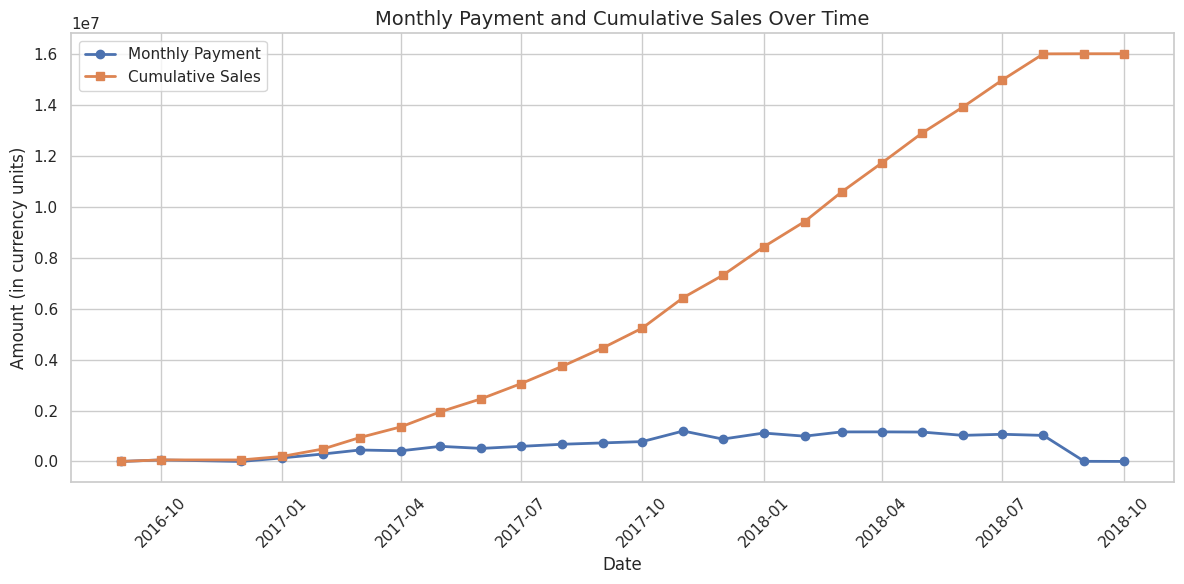

In [14]:
# Step 1: Create a proper datetime column
df['months'] = df['months'].str.zfill(2)  # Ensure '01', '02', ...
df['date'] = pd.to_datetime(df['years'] + '-' + df['months'] + '-01')

# Step 2: Clean data
df['payment'] = pd.to_numeric(df['payment'], errors='coerce')
df['cumulative_sales'] = pd.to_numeric(df['cumulative_sales'], errors='coerce')
df = df.replace([float('inf'), float('-inf')], pd.NA)
df = df.dropna(subset=['payment', 'cumulative_sales', 'date'])

# Step 3: Sort by date
df = df.sort_values('date')

# Step 4: Plot
plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['payment'], label='Monthly Payment', marker='o', linewidth=2)
plt.plot(df['date'], df['cumulative_sales'], label='Cumulative Sales', marker='s', linewidth=2)

plt.title("Monthly Payment and Cumulative Sales Over Time", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Amount (in currency units)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Sales date from specific years
query = """ 

WITH a AS (
  SELECT 
    strftime('%Y', orders.order_purchase_timestamp) AS years,
    ROUND(SUM(payments.payment_value), 2) AS payment
  FROM orders 
  JOIN payments ON orders.order_id = payments.order_id
  GROUP BY years 
  ORDER BY years
)
SELECT 
  years, 
  payment AS sales,
  LAG(payment) OVER (ORDER BY years) AS previous_year,
  CASE 
    WHEN LAG(payment) OVER (ORDER BY years) IS NULL THEN NULL
    ELSE ((payment - LAG(payment) OVER (ORDER BY years)) / LAG(payment) OVER (ORDER BY years)) * 100
  END AS yoy_percentage_growth
FROM a;


"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns=['years', 'sales', 'previous_year', 'yoy_percentage_growth'])

# Convert values to float
for col in ['sales', 'previous_year', 'yoy_percentage_growth']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Show cleanly with formatted output (avoids all warnings)
df.style.format({
    'sales': '{:,.2f}',
    'previous_year': '{:,.2f}',
    'yoy_percentage_growth': '{:+.2f}%'
})


,years,sales,previous_year,yoy_percentage_growth
0,2016,"59,362.34",nan,+nan%
1,2017,"7,249,746.73","59,362.34",+12112.70%
2,2018,"8,699,763.05","7,249,746.73",+20.00%


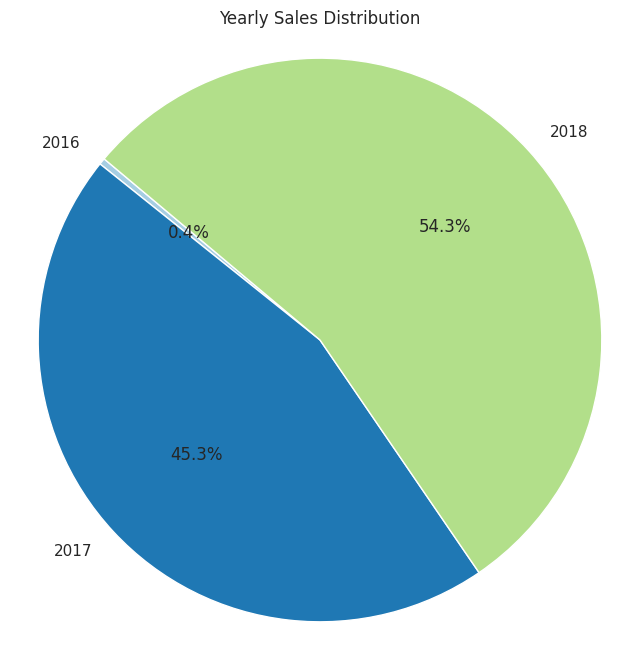

In [16]:
# Pie chart for yearly sales
plt.figure(figsize=(8, 8))
plt.pie(
    df['sales'], 
    labels=df['years'], 
    autopct='%1.1f%%', 
    startangle=140, 
    colors=plt.cm.Paired.colors
)
plt.title('Yearly Sales Distribution')
plt.axis('equal')  # Equal aspect ratio ensures pie is a circle.
plt.show()

In [17]:
query = """

SELECT years, customer_id, payment, d_rank 
FROM (
    SELECT 
        strftime('%Y', orders.order_purchase_timestamp) AS years,
        orders.customer_id,
        SUM(payments.payment_value) AS payment,
        DENSE_RANK() OVER (
            PARTITION BY strftime('%Y', orders.order_purchase_timestamp)
            ORDER BY SUM(payments.payment_value) DESC
        ) AS d_rank
    FROM orders 
    JOIN payments ON payments.order_id = orders.order_id
    GROUP BY years, orders.customer_id
) AS a
WHERE d_rank <= 3;


"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns= ['years', 'id', 'payment', 'rank'])

df

,years,id,payment,rank
0,2016,a9dc96b027d1252bbac0a9b72d837fc6,1423.55,1
1,2016,1d34ed25963d5aae4cf3d7f3a4cda173,1400.74,2
2,2016,4a06381959b6670756de02e07b83815f,1227.78,3
3,2017,1617b1357756262bfa56ab541c47bc16,13664.08,1
4,2017,c6e2731c5b391845f6800c97401a43a9,6929.31,2
5,2017,3fd6777bbce08a352fddd04e4a7cc8f6,6726.66,3
6,2018,ec5b2ba62e574342386871631fafd3fc,7274.88,1
7,2018,f48d464a0baaea338cb25f816991ab1f,6922.21,2
8,2018,e0a2412720e9ea4f26c1ac985f6a7358,4809.44,3


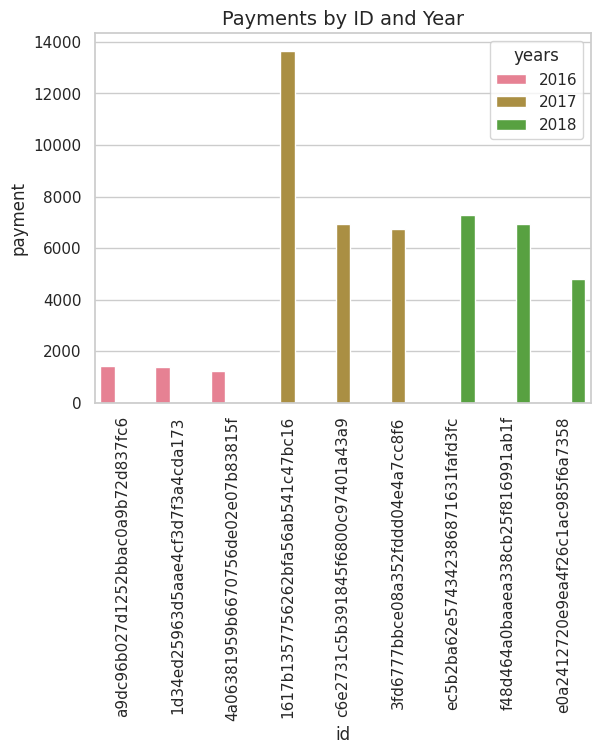

In [18]:
# Stylish color palette (Hue-Saturation-Lightness)

sns.set_style("whitegrid")  # Optional: cleaner background
sns.set_palette("husl")     # Stylish color palette (Hue-Saturation-Lightness)

sns.barplot(x="id", y="payment", data=df, hue="years")
plt.xticks(rotation=90)
plt.title("Payments by ID and Year", fontsize=14)

plt.show()

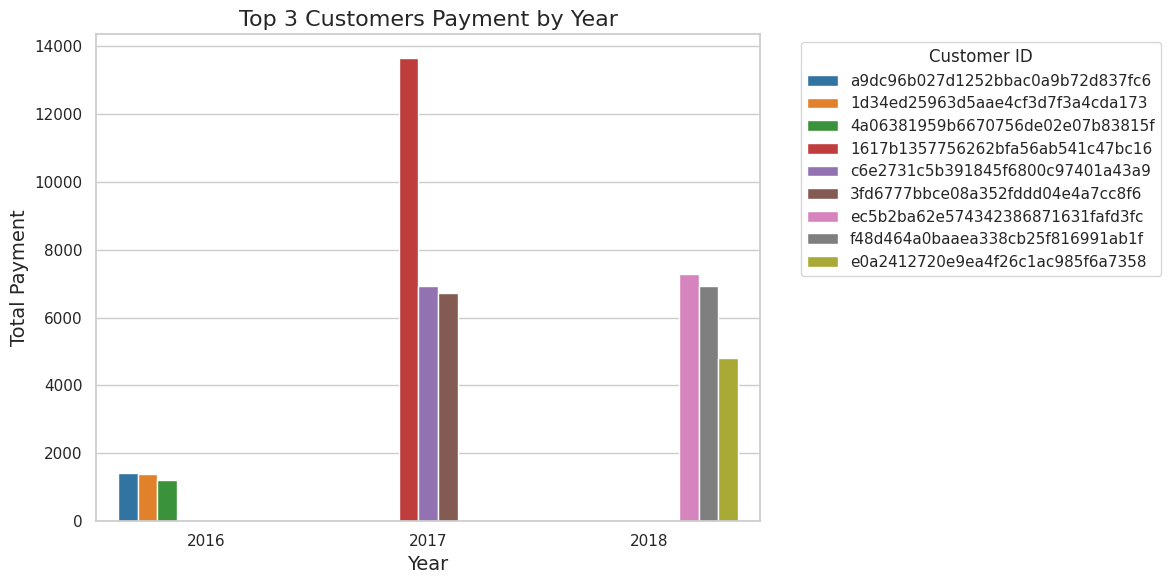

In [19]:
plt.figure(figsize=(12, 6))

# Bar plot with years on x-axis, payment on y-axis, grouped by customer_id
sns.barplot(
    x='years',
    y='payment',
    hue='id',          # Different color for each customer_id
    data=df,
    palette='tab10'    # Color palette
)

plt.title('Top 3 Customers Payment by Year', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Total Payment', fontsize=14)
plt.legend(title='Customer ID', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

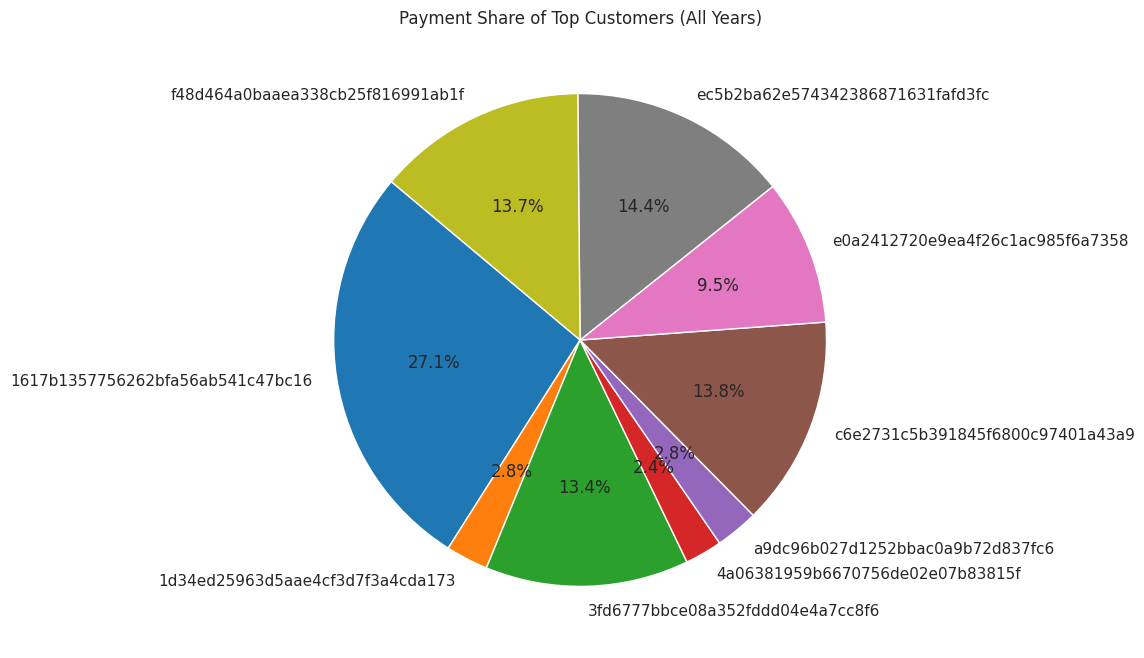

In [20]:
# Aggregate total payment per customer (across all years)
pie_data = df.groupby('id')['payment'].sum().reset_index()

plt.figure(figsize=(8, 8))
plt.pie(
    pie_data['payment'],
    labels=pie_data['id'],
    autopct='%1.1f%%',
    startangle=140,
    colors=sns.color_palette('tab10', len(pie_data))
)
plt.title('Payment Share of Top Customers (All Years)')
plt.show()

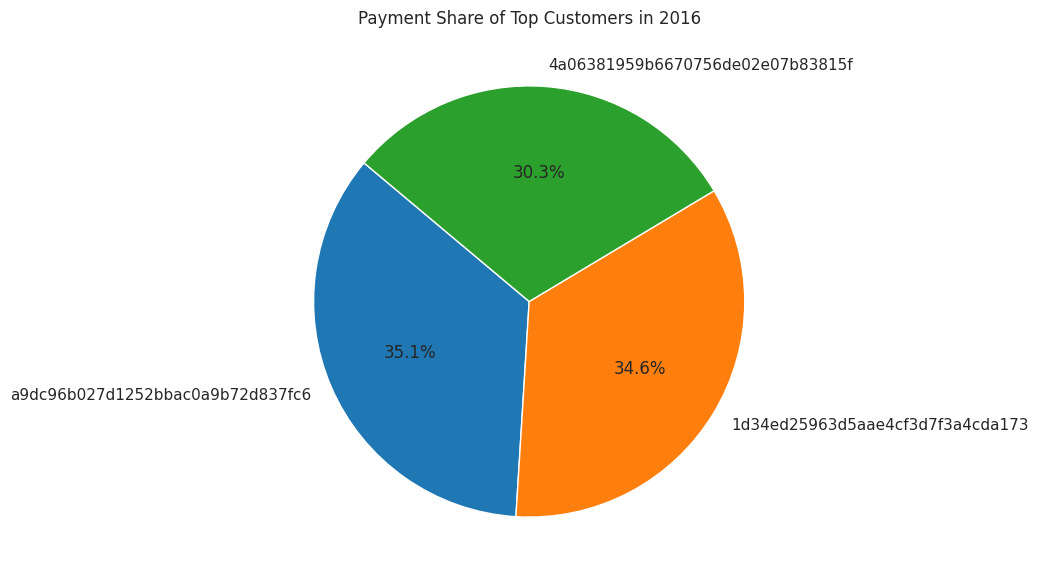

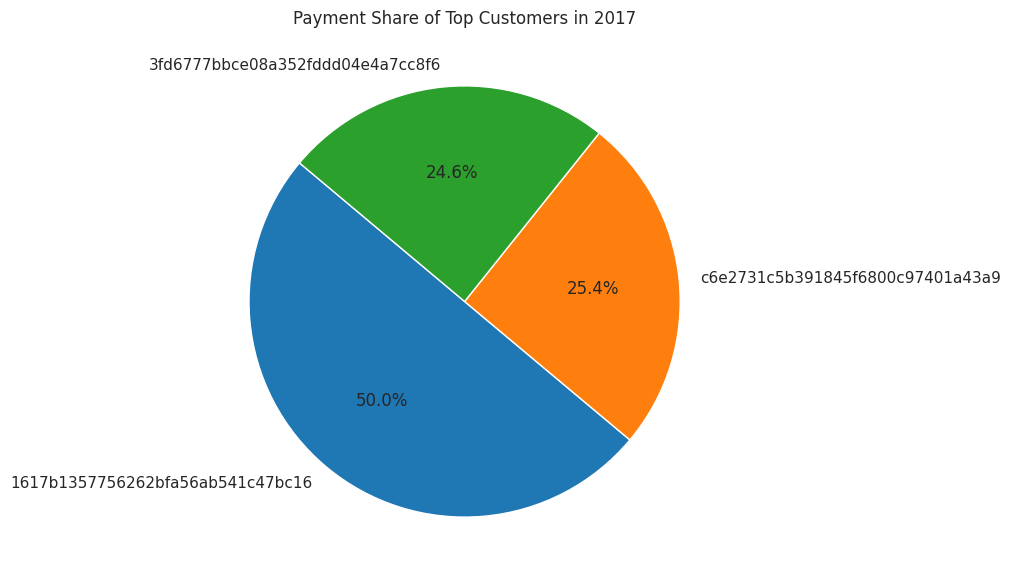

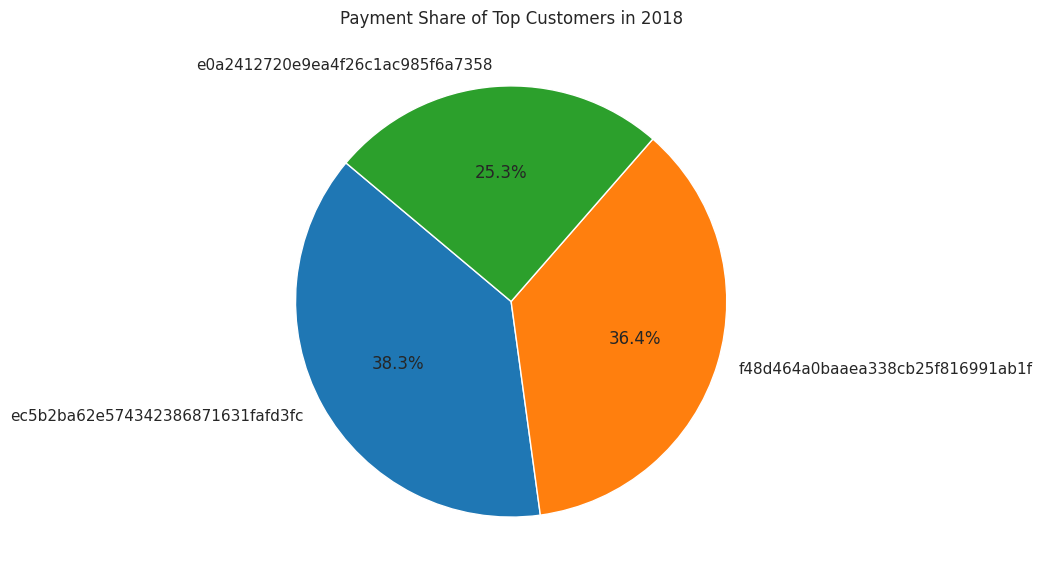

In [21]:
years = df['years'].unique()

for year in years:
    yearly_data = df[df['years'] == year].copy()
    plt.figure(figsize=(7, 7))
    plt.pie(
        yearly_data['payment'],
        labels=yearly_data['id'],
        autopct='%1.1f%%',
        startangle=140,
        colors=sns.color_palette('tab10', len(yearly_data))
    )
    plt.title(f'Payment Share of Top Customers in {year}')
    plt.show()